# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import pandas as pd

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


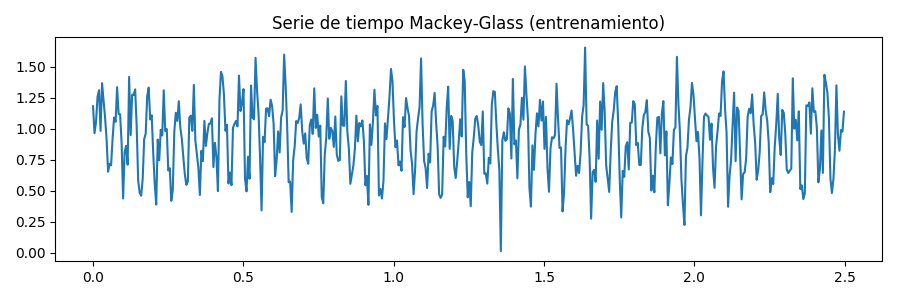

In [3]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

## Respuestas

### 1.
### El filtro de Wiener básico consistiría en obtener los coeficientes de un sistema LTI después de un paso previo deterministico de "entrenamiento" del cual si el sistema LTI obtenido se convoluciona con la señal diseñada debe ser capaz de cumplir su objetivo de filtrado.
### A diferencia del algoritmo de LMS que consiste en la obtención de un sistema adaptativo tal que actualiza recursivamente sus pesos con su matriz de correlación instantanea.
### La principal semejanza es el de la función final de ambos algoritmos de filtro si se les entrena igual, pero la diferencia principal es que Wiener considerando la muestra de entrenamiento dada, ésta sería optima, mientras que LMS no lo sería (aunque tendería a serlo) pero al ser capaz de ser modificada a medida en tiempo real sin necesidad de repetir todo el algoritmo con la nueva información, se obtiene una optimización del lado del rendimiento muy considerable.

### 2.
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e²_n \textbf{u}_{n}\nonumber \\
\end{align}
$$

### 3.


$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$

In [5]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        ## d es la señal deseada
        ## u es la señal obtenida con ruido
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(d - np.transpose(self.w)*u)*u

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajusta el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


## 1.

In [63]:
mu = np.logspace(-2, 0, num=20)
print(mu)
L = [5, 10, 20, 30]

tabla = np.zeros((len(mu), len(L)*2))
#print(tabla)
conti = 0
experimentos = [ [],[],[],[] ]
contind = 0
for i in mu:
    contj = 0
    contind = 0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        if (conti == 0):
            experimentos[contind] = y_pred;
        tabla[conti][contj] = np.format_float_scientific(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 7)
        tabla[conti][contj+1] = np.format_float_scientific(NMSE(ymg[500:], y_pred[500:]), 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        contind += 1
        contj += 2
    conti += 1

[0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818
 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499
 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]


## 2.

In [40]:
pd.DataFrame(tabla, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

,5_entrenamiento,5_prueba,10_entrenamiento,10_prueba,20_entrenamiento,20_prueba,30_entrenamiento,30_prueba
0,88359.051,107971.64,446169.58,550759.56,1967357.7,2497088.4,4463353.5,5918920.9
1,92764.028,107890.83,466907.63,550238.62,2057413.8,2498870.6,4671637.6,5943786.2
2,96240.240,107724.48,483164.63,549139.21,2128084.0,2498124.1,4835542.6,5967010.9
3,98993.294,107502.10,495888.85,547547.44,2183417.5,2494645.1,4964297.9,5988648.3
4,101194.020,107289.84,505860.99,545685.43,2226728.4,2488195.5,5065431.3,6007457.5
5,102985.660,107225.70,513732.24,544073.00,2260763.5,2479298.1,5145135.5,6022306.0
6,104492.180,107536.73,520064.36,543638.91,2287888.5,2470115.4,5208706.6,6034073.5
7,105827.610,108544.97,525368.03,545847.60,2310270.2,2465630.5,5260984.0,6049063.4
8,107107.150,110651.87,530146.85,552804.39,2330076.6,2474557.7,5306821.3,6082496.8
9,108459.700,114266.73,534955.71,567214.99,2349723.1,2508984.4,5351640.5,6159444.8


## 3.

## Con 𝜇=0.01 y L=5

<IPython.core.display.Javascript object>


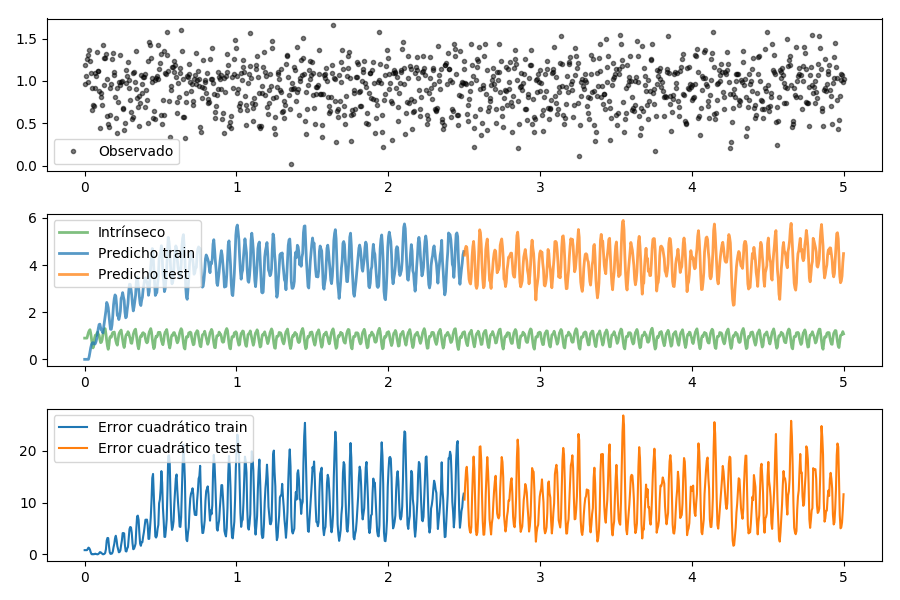

In [59]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos[0][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos[0][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos[0][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos[0][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Con 𝜇=0.01 y L=10

<IPython.core.display.Javascript object>


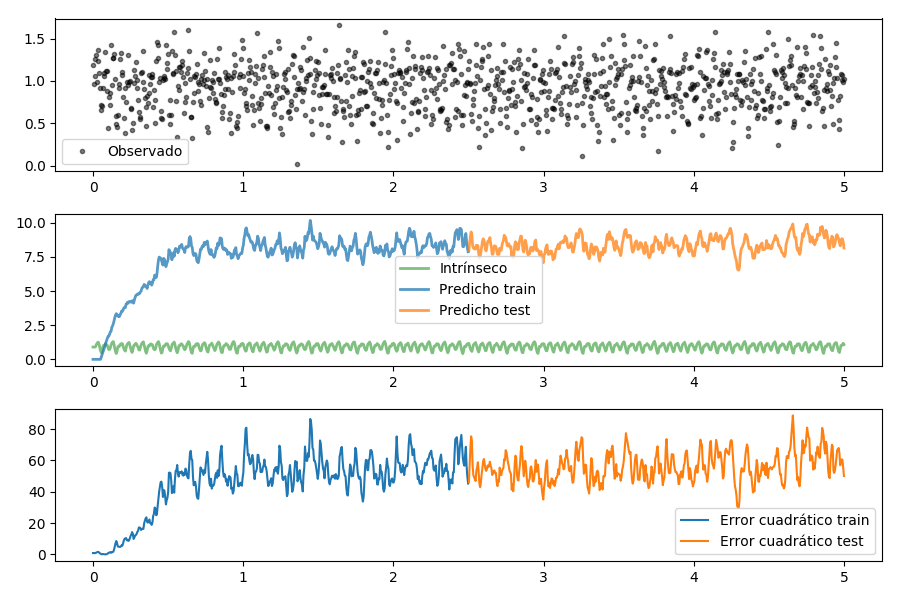

In [60]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos[1][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos[1][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos[1][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos[1][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Con 𝜇=0.01 y L=20

<IPython.core.display.Javascript object>


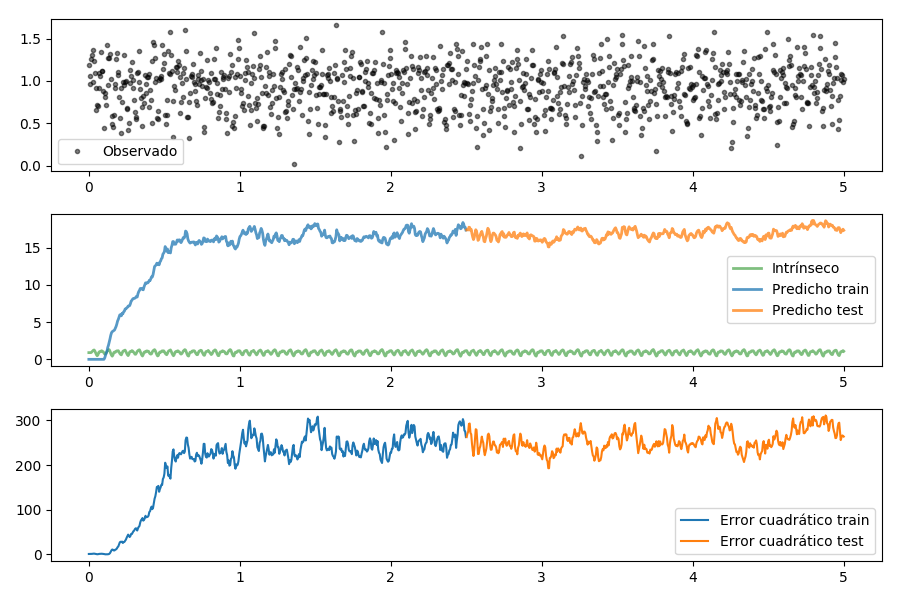

In [61]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos[2][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos[2][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos[2][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos[2][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Con 𝜇=0.01 y L=30

<IPython.core.display.Javascript object>


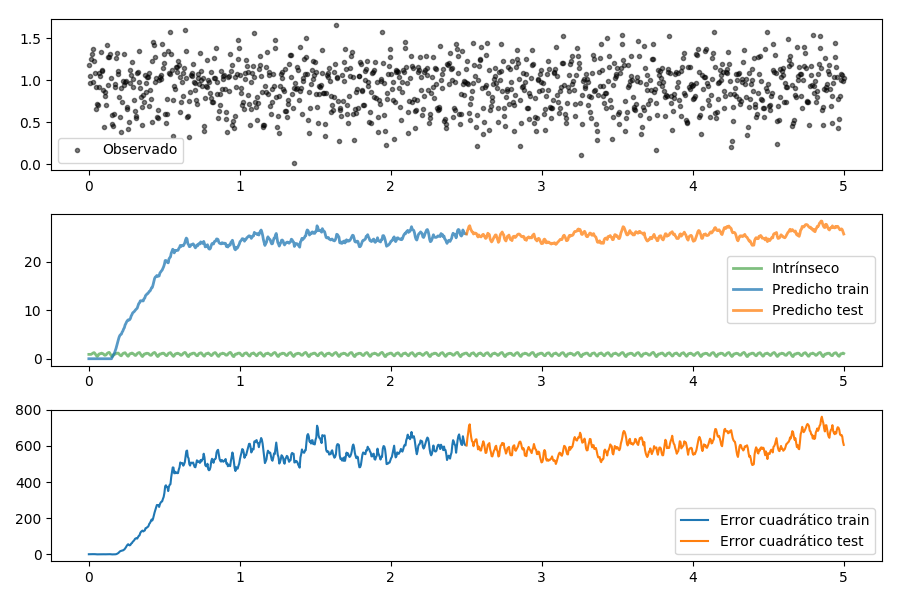

In [62]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], experimentos[3][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos[3][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos[3][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos[3][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

In [7]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = ?
        self.w = ?
        

SyntaxError: invalid syntax (<ipython-input-7-93393a4dd763>, line 21)

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


In [1]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

NameError: name 'RLS_filter' is not defined

In [ ]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)